Harsh Bhardwaj

In [1]:
import pandas as pd
df = pd.read_csv("C:\\Users\\rituh\\Downloads\\train.csv")
print(df.shape)
print(df.columns.tolist())
print(df.head())

(3192, 14)
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Employment_Status', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Loan_Term', 'Credit_History', 'Property_Area', 'Age', 'Loan_Status']
   Loan_ID  Gender Married  Dependents     Education Employment_Status  \
0  LN03437  Female     Yes           3      Graduate          Salaried   
1  LN04823  Female     Yes           1      Graduate     Self-Employed   
2  LN04186  Female     Yes           1  Not Graduate          Salaried   
3  LN00380    Male     Yes           2      Graduate          Salaried   
4  LN04698  Female     Yes           0      Graduate          Salaried   

   Applicant_Income  Coapplicant_Income    Loan_Amount  Loan_Term  \
0      34473.911669        13914.721574  240732.458366        180   
1      59718.020682        18720.814787  122547.278442        180   
2     106981.515734         2229.154377  140550.937774         60   
3      43205.563156        35578.111771  146135.738127      

In [2]:
df = df.drop(columns=['Loan_ID'])

In [3]:
df['Loan_Status'] = df['Loan_Status'].map({'Approved': 1, 'Rejected': 0})


In [4]:
num_cols = [
    'Applicant_Income',
    'Coapplicant_Income',
    'Loan_Amount',
    'Loan_Term',
    'Age'
]

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())


In [5]:
cat_cols = [
    'Gender',
    'Married',
    'Dependents',
    'Education',
    'Employment_Status',
    'Credit_History',
    'Property_Area'
]

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [6]:
df['Total_Income'] = df['Applicant_Income'] + df['Coapplicant_Income']
df['Loan_to_Income_Ratio'] = df['Loan_Amount'] / df['Total_Income']


In [7]:
df = pd.get_dummies(df, drop_first=True)


In [8]:
from sklearn.model_selection import train_test_split

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.value_counts(normalize=True))


(2553, 16)
(639, 16)
Loan_Status
1    0.500196
0    0.499804
Name: proportion, dtype: float64


In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


In [11]:
approved = (y == 1).sum()
rejected = (y == 0).sum()

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=rejected / approved,
    eval_metric="logloss",
    random_state=42
)


In [12]:
xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [13]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]


In [14]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


Accuracy: 0.9796557120500783
ROC-AUC: 0.99858934169279
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       320
           1       0.97      0.99      0.98       319

    accuracy                           0.98       639
   macro avg       0.98      0.98      0.98       639
weighted avg       0.98      0.98      0.98       639



In [15]:
import pandas as pd

feature_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print(feature_importance.head(10))


Credit_History                     0.895722
Education_Not Graduate             0.012876
Loan_to_Income_Ratio               0.010974
Employment_Status_Self-Employed    0.010425
Property_Area_Urban                0.009998
Employment_Status_Unemployed       0.008952
Total_Income                       0.007769
Coapplicant_Income                 0.006208
Loan_Amount                        0.005978
Married_Yes                        0.005726
dtype: float32


In [16]:
import joblib

joblib.dump(xgb_model, "xgboost_loan_model.pkl")
joblib.dump(X_train.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']

In [17]:
import shap
import numpy as np


In [18]:
explainer = shap.TreeExplainer(xgb_model)


In [19]:
shap_values = explainer.shap_values(X_test)


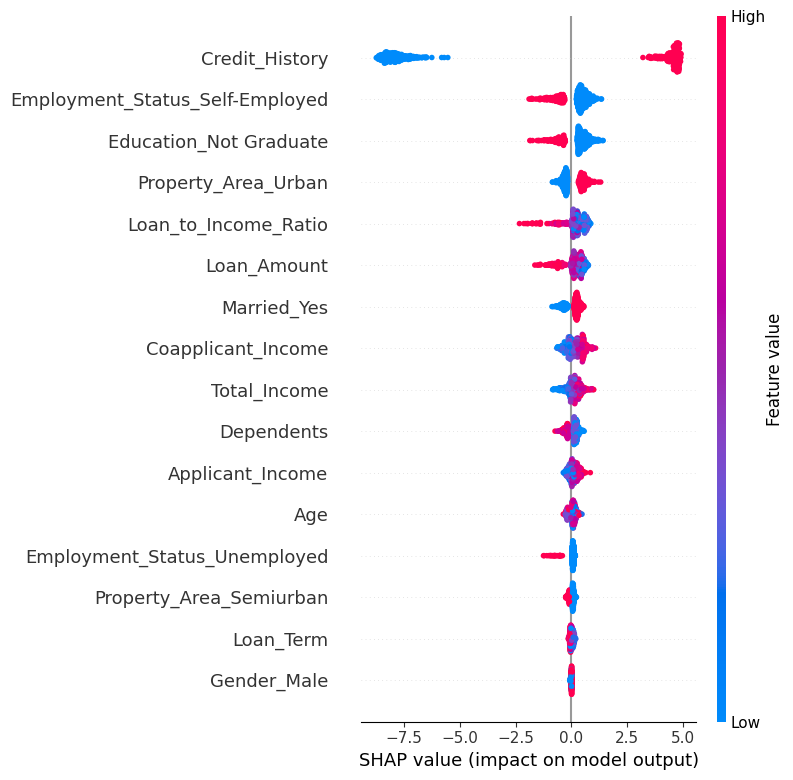

In [20]:
shap.summary_plot(shap_values, X_test)


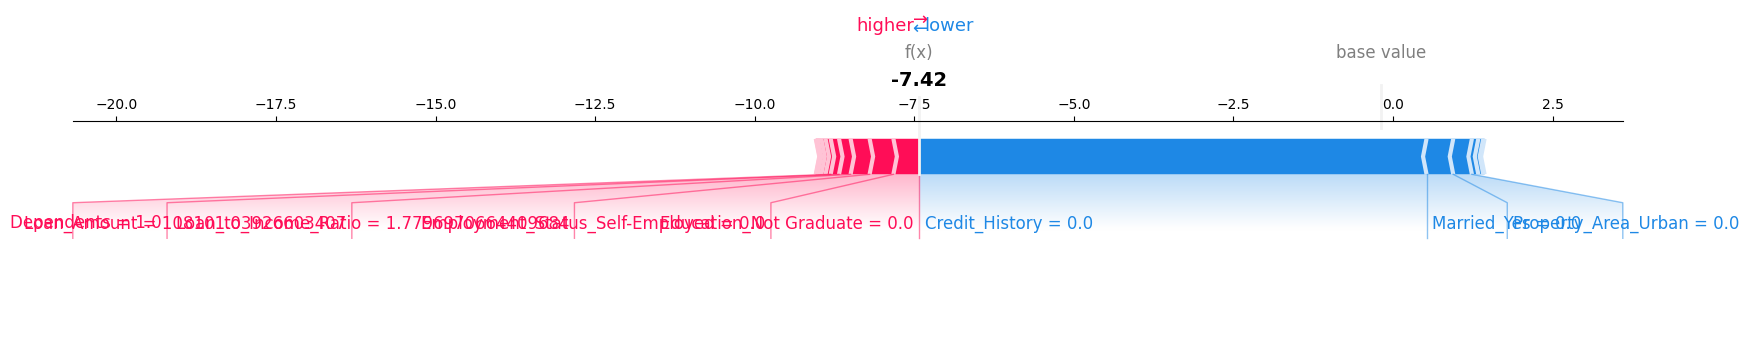

In [21]:
i = 0  # index of test sample
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test.iloc[i],
    matplotlib=True
)


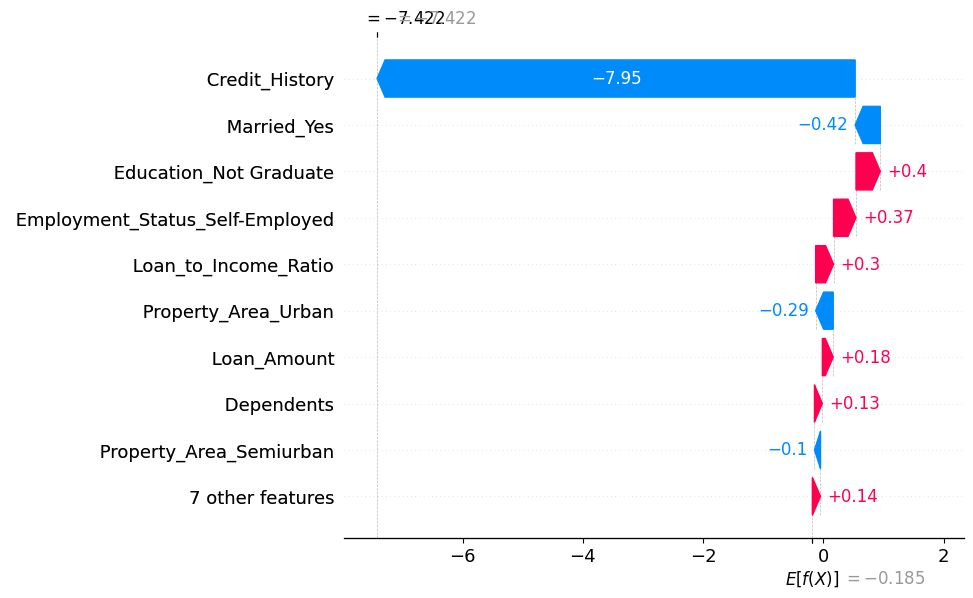

In [22]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[i],
    X_test.iloc[i]
)


In [23]:
import pickle

with open("shap_explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)


In [24]:
from lime.lime_tabular import LimeTabularExplainer


In [25]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Rejected', 'Approved'],
    mode='classification'
)


In [26]:
i = 0  # any index

lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[i].values,
    predict_fn=xgb_model.predict_proba,
    num_features=10
)


In [27]:

lime_exp.save_to_file("lime_explanation.html")
